###In this lab, initially, preliminary data underwent preprocessing and tokenization prior to model fine-tuning. Later, model undergoes training and fine-tuning using the preliminary dataset, detailed in the methodology chapter and provided in the [data section](https://github.com/ImRezar/Sentiment-and-Attitude-in-Posts-by-Iranian-and-Non--Iranian-News-Agencies-on-X-Regarding/blob/main/Training%20Data). Subsequently, social media posts from platform X, representing each news agency, were inputted into the model for sentiment prediction. The accompanying code quantifies the model's sentiment predictions, presenting the percentage of negative and positive sentiment attributed to each news agency based on the supplied data.

In [ ]:
#First the necessary libraries imported
!pip install transformers datasets
import pandas as pd
import matplotlib.pyplot as plt
import torch
import numpy as np
import tensorflow as tf
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from transformers import create_optimizer
from transformers import TFAutoModelForSequenceClassification
from transformers import pipeline, AutoTokenizer

In [2]:
df=pd.read_excel("/content/Train Data FA.xlsx")
#This code provides a preliminary overview of the dataset by displaying the first five rows
df.head()

,Text,Label
0,وزارت خارجه سعودی: تصمیم دولت اشغالگر اسرائیل ...,0
1,ساکنان غزه با خطر جدی گرسنگی مواجه هستند,0
2,بنیامین نتانیاهو، نخست‌وزیر اسرائیل، شامگاه چه...,1
3,جنگنده‌های رژیم صهیونیستی مناطق شمالی نوار غزه...,0
4,رسانه های فلسطینی: در پی حمله اسرائیل به بیمار...,0


####Prior to preprocessing, it is imperative to acknowledge the class imbalance present within the dataset utilized for training and fine-tuning. Specifically, the dataset exhibits an overrepresentation of negative social media posts (labeled 0) with 506 instances compared to 194 positive posts (labeled 1). Such class imbalance can potentially bias the model towards the majority class. To mitigate this, a class weighting strategy was employed, assigning higher weights to the underrepresented class to ensure equitable representation during training. Here, this is achieved through the incorporation the weight class argument within the training process. The subsequent code illustrates the class distribution within the dataset.

The class distribution is as follows: Label
0    506
1    194
Name: count, dtype: int64


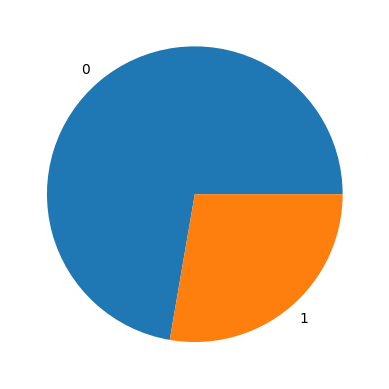

In [3]:
vc= df.value_counts('Label')
print("The class distribution is as follows:", vc)
plt.pie(vc.values, labels=vc.index);

In [4]:
#Firstly, the data has to be converted to numpy arrays so that the data points can be poured into a list
train=df[:550]

train=np.array(train)

validation=df[550:]

validation= np.array(validation)
#This code provides the dimensions of the training and validation sets
train.shape, validation.shape

((550, 2), (150, 2))

In [5]:
train_text = []
train_labels = []
validation_text = []
validation_labels = []

for s,l in train:
  train_text.append(s)
  train_labels.append(l)

for s,l in validation:
  validation_text.append(s)
  validation_labels.append(l)

#Again, since the lables do not need tokenization, they are converted to a numpy array for model training
train_labels = np.array(train_labels)
validation_labels = np.array(validation_labels)

In [ ]:
#The following cell will tokenize the text in train and validation set
#The tokenizer employed is the model's inherent tokenizer.
tokenizer = AutoTokenizer.from_pretrained("rezaFarsh/ternary_persian_sentiment_analysis")

#This code will pad the data (part of the preprocessing)
sequences_train_text = tokenizer(train_text, truncation=True, padding=True, max_length=300, return_tensors='tf')
sequences_validation_text = tokenizer(validation_text, truncation=True, padding=True, max_length=300, return_tensors='tf')

#The following code makes the labeling more clear;
id2label = {0: "NEGATIVE", 1: "POSITIVE"}
label2id = {"NEGATIVE": 0, "POSITIVE": 1}

#The following code also encodes the data to tensors which is necessary for the training
def batch_encoding_to_tensors(batch_encoding):
  return {key: tf.convert_to_tensor(value) for key, value in batch_encoding.items()}

sequences_train_text_tensors = batch_encoding_to_tensors(sequences_train_text)
sequences_validation_text_tensors = batch_encoding_to_tensors(sequences_validation_text)

In [ ]:
#These yperparameter selection was informed by an extensive optimization process culminating in the identification of parameters yielding optimal performance
batch_size = 16
num_epochs=25
batches_per_epoch = len(train_text) // batch_size
total_train_steps = int(batches_per_epoch * num_epochs)
#The chosen optimizer was similarly determined through empirical experimentation.
optimizer, schedule = create_optimizer(init_lr=2e-5, num_warmup_steps=0, num_train_steps=total_train_steps)

#The pretrained model stated perivously, is called
model = TFAutoModelForSequenceClassification.from_pretrained("rezaFarsh/ternary_persian_sentiment_analysis",
                                  num_labels=2, id2label=id2label, label2id=label2id, ignore_mismatched_sizes=True)

In [8]:
#The model was trained on the preprocessed and tokenized text, with accuracy metrics generated throughout the process.
#A training epoch of 20 iterations was established
#based on previous experiments demonstrating diminishing returns beyond this threshold, often as early as 15 epochs.
#The class weight argument mentioned above is used
#to ensure that the model doesn't model might become biased towards the negative class
model.compile(optimizer=optimizer, metrics=['accuracy'])
class_weights = {0: 0.3, 1: 0.7}
model.fit(sequences_train_text_tensors, train_labels, epochs=num_epochs, batch_size= batch_size,
          validation_data=(sequences_validation_text_tensors, validation_labels), class_weight=class_weights)

Epoch 1/25
35/35 [==============================] - 62s 576ms/step - loss: 0.2242 - accuracy: 0.7327 - val_loss: 0.3107 - val_accuracy: 0.8933
Epoch 2/25
35/35 [==============================] - 17s 500ms/step - loss: 0.0788 - accuracy: 0.9382 - val_loss: 0.1985 - val_accuracy: 0.9333
Epoch 3/25
35/35 [==============================] - 18s 508ms/step - loss: 0.0371 - accuracy: 0.9727 - val_loss: 0.2193 - val_accuracy: 0.9333
Epoch 4/25
35/35 [==============================] - 18s 515ms/step - loss: 0.0192 - accuracy: 0.9873 - val_loss: 0.1680 - val_accuracy: 0.9467
Epoch 5/25
35/35 [==============================] - 18s 523ms/step - loss: 0.0078 - accuracy: 0.9982 - val_loss: 0.1834 - val_accuracy: 0.9467
Epoch 6/25
35/35 [==============================] - 18s 530ms/step - loss: 0.0049 - accuracy: 0.9982 - val_loss: 0.1871 - val_accuracy: 0.9467
Epoch 7/25
35/35 [==============================] - 18s 519ms/step - loss: 0.0034 - accuracy: 0.9964 - val_loss: 0.2066 - val_accuracy: 0.9467

####A standardized code was executed eight times, once for each news agency, to ensure consistency and eliminate confounding variables. The code involved the application of a fine-tuned model to each agency's dataset, followed by the calculation of positive and negative sentiment percentages as determined by the model.

In [9]:
#Fars News Agency
Fars = pd.read_excel("/content/Fars.xlsx")

tokenizer = AutoTokenizer.from_pretrained("rezaFarsh/ternary_persian_sentiment_analysis")

def preprocess_text(text):
    return tokenizer(text, padding='max_length', truncation=True, return_tensors='tf')

def predict_sentiment(text):
    inputs = preprocess_text(text)
    with torch.no_grad():
        outputs = model(**inputs)
        logits = outputs.logits
        logits = torch.from_numpy(logits.numpy())
        predicted_class_id = torch.argmax(logits, dim=1).item()
    return predicted_class_id
def calculate_sentiment_percentage(sentiments):
    total = len(sentiments)
    positive = sum(sentiments)
    negative = total - positive
    positive_percentage = (positive / total) * 100
    negative_percentage = (negative / total) * 100
    return positive_percentage, negative_percentage


Fars['sentiment'] = Fars['Text'].apply(predict_sentiment)

sentiments = Fars['sentiment'].tolist()
positive_percentage, negative_percentage = calculate_sentiment_percentage(sentiments)s

print(f"Positive sentiment in Fars News Agency: {positive_percentage:.2f}%")
print(f"Negative sentiment in Fars News Agency: {negative_percentage:.2f}%")

Positive sentiment in Fars News Agency: 11.25%
Negative sentiment in Fars News Agency: 88.75%


In [10]:
#IRNA News Agency
Irna = pd.read_excel("/content/IRNA.xlsx")

tokenizer = AutoTokenizer.from_pretrained("rezaFarsh/ternary_persian_sentiment_analysis")

def preprocess_text(text):
    return tokenizer(text, padding='max_length', truncation=True, return_tensors='tf')

def predict_sentiment(text):
    inputs = preprocess_text(text)
    with torch.no_grad():
        outputs = model(**inputs)
        logits = outputs.logits
        logits = torch.from_numpy(logits.numpy())
        predicted_class_id = torch.argmax(logits, dim=1).item()
    return predicted_class_id
def calculate_sentiment_percentage(sentiments):
    total = len(sentiments)
    positive = sum(sentiments)
    negative = total - positive
    positive_percentage = (positive / total) * 100
    negative_percentage = (negative / total) * 100
    return positive_percentage, negative_percentage

Irna['sentiment'] = Irna['Text'].apply(predict_sentiment)

sentiments = Irna['sentiment'].tolist()
positive_percentage, negative_percentage = calculate_sentiment_percentage(sentiments)

print(f"Positive sentiment in IRNA News Agency: {positive_percentage:.2f}%")
print(f"Negative sentiment in IRNA News Agency: {negative_percentage:.2f}%")

Positive sentiment in IRNA News Agency: 18.75%
Negative sentiment in IRNA News Agency: 81.25%


In [11]:
#Shargh News Agency
Shargh = pd.read_excel("/content/Shargh.xlsx")

tokenizer = AutoTokenizer.from_pretrained("rezaFarsh/ternary_persian_sentiment_analysis")

def preprocess_text(text):
    return tokenizer(text, padding='max_length', truncation=True, return_tensors='tf')

def predict_sentiment(text):
    inputs = preprocess_text(text)
    with torch.no_grad():
        outputs = model(**inputs)
        logits = outputs.logits
        logits = torch.from_numpy(logits.numpy())
        predicted_class_id = torch.argmax(logits, dim=1).item()
    return predicted_class_id
def calculate_sentiment_percentage(sentiments):
    total = len(sentiments)
    positive = sum(sentiments)
    negative = total - positive
    positive_percentage = (positive / total) * 100
    negative_percentage = (negative / total) * 100
    return positive_percentage, negative_percentage

Shargh['sentiment'] = Shargh['Text'].apply(predict_sentiment)

sentiments = Shargh['sentiment'].tolist()
positive_percentage, negative_percentage = calculate_sentiment_percentage(sentiments)

print(f"Positive sentiment in Shargh News Agency: {positive_percentage:.2f}%")
print(f"Negative sentiment in Shargh News Agency: {negative_percentage:.2f}%")

Positive sentiment in Shargh News Agency: 16.25%
Negative sentiment in Shargh News Agency: 83.75%


In [12]:
#Etemad News Agency
Etemad = pd.read_excel("/content/Etemad.xlsx")

tokenizer = AutoTokenizer.from_pretrained("rezaFarsh/ternary_persian_sentiment_analysis")

def preprocess_text(text):
    return tokenizer(text, padding='max_length', truncation=True, return_tensors='tf')

def predict_sentiment(text):
    inputs = preprocess_text(text)
    with torch.no_grad():
        outputs = model(**inputs)
        logits = outputs.logits
        logits = torch.from_numpy(logits.numpy())
        predicted_class_id = torch.argmax(logits, dim=1).item()
    return predicted_class_id
def calculate_sentiment_percentage(sentiments):
    total = len(sentiments)
    positive = sum(sentiments)
    negative = total - positive
    positive_percentage = (positive / total) * 100
    negative_percentage = (negative / total) * 100
    return positive_percentage, negative_percentage

Etemad['sentiment'] = Etemad['Text'].apply(predict_sentiment)

sentiments = Etemad['sentiment'].tolist()
positive_percentage, negative_percentage = calculate_sentiment_percentage(sentiments)

print(f"Positive sentiment in Etemad News Agency: {positive_percentage:.2f}%")
print(f"Negative sentiment in Etemad News Agency: {negative_percentage:.2f}%")

Positive sentiment in Etemad News Agency: 6.25%
Negative sentiment in Etemad News Agency: 93.75%


In [13]:
#BBC Farsi News Agency
BBC_Farsi = pd.read_excel("/content/BBC Farsi.xlsx")

tokenizer = AutoTokenizer.from_pretrained("rezaFarsh/ternary_persian_sentiment_analysis")

def preprocess_text(text):
    return tokenizer(text, padding='max_length', truncation=True, return_tensors='tf')

def predict_sentiment(text):
    inputs = preprocess_text(text)
    with torch.no_grad():
        outputs = model(**inputs)
        logits = outputs.logits
        logits = torch.from_numpy(logits.numpy())
        predicted_class_id = torch.argmax(logits, dim=1).item()
    return predicted_class_id
def calculate_sentiment_percentage(sentiments):
    total = len(sentiments)
    positive = sum(sentiments)
    negative = total - positive
    positive_percentage = (positive / total) * 100
    negative_percentage = (negative / total) * 100
    return positive_percentage, negative_percentage

BBC_Farsi['sentiment'] = BBC_Farsi['Text'].apply(predict_sentiment)

sentiments = BBC_Farsi['sentiment'].tolist()
positive_percentage, negative_percentage = calculate_sentiment_percentage(sentiments)

print(f"Positive sentiment in BBC Farsi News Agency: {positive_percentage:.2f}%")
print(f"Negative sentiment in BBC Farsi News Agency: {negative_percentage:.2f}%")

Positive sentiment in BBC Farsi News Agency: 18.75%
Negative sentiment in BBC Farsi News Agency: 81.25%


In [14]:
#DW Farsi News Agency
DW_Farsi= pd.read_excel("/content/DW farsi.xlsx")

tokenizer = AutoTokenizer.from_pretrained("rezaFarsh/ternary_persian_sentiment_analysis")

def preprocess_text(text):
    return tokenizer(text, padding='max_length', truncation=True, return_tensors='tf')

def predict_sentiment(text):
    inputs = preprocess_text(text)
    with torch.no_grad():
        outputs = model(**inputs)
        logits = outputs.logits
        logits = torch.from_numpy(logits.numpy())
        predicted_class_id = torch.argmax(logits, dim=1).item()
    return predicted_class_id
def calculate_sentiment_percentage(sentiments):
    total = len(sentiments)
    positive = sum(sentiments)
    negative = total - positive
    positive_percentage = (positive / total) * 100
    negative_percentage = (negative / total) * 100
    return positive_percentage, negative_percentage

DW_Farsi['sentiment'] = DW_Farsi['Text'].apply(predict_sentiment)

sentiments = DW_Farsi['sentiment'].tolist()
positive_percentage, negative_percentage = calculate_sentiment_percentage(sentiments)

print(f"Positive sentiment in DW Farsi News Agency: {positive_percentage:.2f}%")
print(f"Negative sentiment in DW Farsi News Agency: {negative_percentage:.2f}%")

Positive sentiment in DW Farsi News Agency: 11.25%
Negative sentiment in DW Farsi News Agency: 88.75%


In [15]:
#VOA Farsi News Agency
VOA_Farsi = pd.read_excel("/content/VOA Farsi.xlsx")

tokenizer = AutoTokenizer.from_pretrained("rezaFarsh/ternary_persian_sentiment_analysis")

def preprocess_text(text):
    return tokenizer(text, padding='max_length', truncation=True, return_tensors='tf')

def predict_sentiment(text):
    inputs = preprocess_text(text)
    with torch.no_grad():
        outputs = model(**inputs)
        logits = outputs.logits
        logits = torch.from_numpy(logits.numpy())
        predicted_class_id = torch.argmax(logits, dim=1).item()
    return predicted_class_id
def calculate_sentiment_percentage(sentiments):
    total = len(sentiments)
    positive = sum(sentiments)
    negative = total - positive
    positive_percentage = (positive / total) * 100
    negative_percentage = (negative / total) * 100
    return positive_percentage, negative_percentage

VOA_Farsi['sentiment'] = VOA_Farsi['Text'].apply(predict_sentiment)

sentiments = VOA_Farsi['sentiment'].tolist()
positive_percentage, negative_percentage = calculate_sentiment_percentage(sentiments)

print(f"Positive sentiment in VOA Farsi News Agency: {positive_percentage:.2f}%")
print(f"Negative sentiment in VOA Farsi News Agency: {negative_percentage:.2f}%")

Positive sentiment in VOA Farsi News Agency: 22.50%
Negative sentiment in VOA Farsi News Agency: 77.50%


In [16]:
#Iran International News Agency
Iran_International = pd.read_excel("/content/Iran International.xlsx")

tokenizer = AutoTokenizer.from_pretrained("rezaFarsh/ternary_persian_sentiment_analysis")

def preprocess_text(text):
    return tokenizer(text, padding='max_length', truncation=True, return_tensors='tf')

def predict_sentiment(text):
    inputs = preprocess_text(text)
    with torch.no_grad():
        outputs = model(**inputs)
        logits = outputs.logits
        logits = torch.from_numpy(logits.numpy())
        predicted_class_id = torch.argmax(logits, dim=1).item()
    return predicted_class_id
def calculate_sentiment_percentage(sentiments):
    total = len(sentiments)
    positive = sum(sentiments)
    negative = total - positive
    positive_percentage = (positive / total) * 100
    negative_percentage = (negative / total) * 100
    return positive_percentage, negative_percentage

Iran_International['sentiment'] = Iran_International['Text'].apply(predict_sentiment)

sentiments = Iran_International['sentiment'].tolist()
positive_percentage, negative_percentage = calculate_sentiment_percentage(sentiments)

print(f"Positive sentiment in Iran International News Agency: {positive_percentage:.2f}%")
print(f"Negative sentiment in Iran International News Agency: {negative_percentage:.2f}%")

Positive sentiment in Iran International News Agency: 37.50%
Negative sentiment in Iran International News Agency: 62.50%
